In [1]:
# =========================
# CELL 1 — Imports & setup
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi  # (not used directly, but fine to keep)

# --- File path to your dataset ---
CSV_PATH = r"C:\Users\Vex\Desktop\main\dataset\matchday\clean_matchday_stat.csv"

# --- Team names (must match dataset exactly) ---
TEAM_A = "Bayer Leverkusen"
TEAM_B = "Bayern Munich"

# Load dataset once; later cells reuse 'df'
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)


Loaded: (306, 77)


In [2]:
# ======================================================================
# CELL 2 — Robust KPI prep: real matchdays + domain-bounded normalization
#          - Parse dates to build TRUE chronological matchdays
#          - Extract raw KPIs per team
#          - Normalize KPIs into a safe band [0.05, 0.95] to avoid 0/1
# ======================================================================

import pandas as pd
import numpy as np
from math import isfinite

# ----------------------------
# 1) Utilities
# ----------------------------
def _clean_num(v, is_pct=False):
    """
    Convert strings like '54%', '1,234' to numeric.
    Returns NaN if parsing fails; leaves numerics unchanged.
    """
    if isinstance(v, str):
        v = v.replace('%', '').replace(',', '').strip()
    return pd.to_numeric(v, errors='coerce')

def _safe_div(a, b):
    """
    Safe division: returns NaN if b is 0 or either side is NaN.
    """
    if pd.isna(a) or pd.isna(b) or b == 0:
        return np.nan
    return a / b

def _scale_to_band(x, lo, hi, out_lo=0.05, out_hi=0.95):
    """
    Linearly map input range [lo, hi] into [out_lo, out_hi] with clipping.
    Ensures radars never collapse to exactly 0 or 1.
    """
    x = pd.to_numeric(x, errors='coerce')
    y = (x - lo) / (hi - lo + 1e-9)
    y = np.clip(y, 0, 1)
    return out_lo + (out_hi - out_lo) * y

def _parse_match_dt(row):
    """
    Build a datetime from:
      - season_year (e.g., '2023/2024')
      - Date_day (e.g., '18.05' or '18-05')
      - Date_hour (e.g., '16:30')
    Bundesliga season crosses years:
      Jul–Dec -> start year; Jan–May -> start year + 1.
    Falls back to a safe date if parsing fails.
    """
    day_month = str(row.get("Date_day", "")).strip()
    hhmm = str(row.get("Date_hour", "00:00")).strip() or "00:00"

    if "." in day_month:
        d_str, m_str = day_month.split(".", 1)
    else:
        parts = day_month.replace("-", ".").split(".")
        d_str, m_str = (parts + ["1", "1"])[:2]

    try:
        d = int(float(d_str)); m = int(float(m_str))
    except Exception:
        d, m = 1, 7  # fallback: 1 July

    season = str(row.get("season_year", "2023/2024"))
    start_year = int(season.split("/")[0]) if "/" in season else 2023
    year = start_year if m >= 7 else start_year + 1

    try:
        from datetime import datetime
        return datetime.strptime(f"{year:04d}-{m:02d}-{d:02d} {hhmm}", "%Y-%m-%d %H:%M")
    except Exception:
        from datetime import datetime
        return datetime(year, max(1, min(12, m)), max(1, min(28, d)), 0, 0)

# ----------------------------
# 2) Extract raw KPIs for a given team (NO normalization here)
# ----------------------------
def build_team_kpis_raw(df, team_name):
    """
    Iterate fixtures, pick team perspective (home/away),
    compute pass accuracy, and store raw KPIs + chronological matchday.
    """
    rows = []
    for _, row in df.iterrows():
        if row["home_team"] == team_name:
            goals = _clean_num(row.get("home_score"))
            xg    = _clean_num(row.get("expected_goals_xg_home"))
            xga   = _clean_num(row.get("expected_goals_xg_host"))
            poss  = _clean_num(row.get("Ball_Possession_Home"))
            tp    = _clean_num(row.get("Total_Passes_Home"))
            cp    = _clean_num(row.get("Completed_Passes_Home"))
            dang  = _clean_num(row.get("Dangerous_Attacks_Home"))
        elif row["away_team"] == team_name:
            goals = _clean_num(row.get("away_score"))
            xg    = _clean_num(row.get("expected_goals_xg_host"))
            xga   = _clean_num(row.get("expected_goals_xg_home"))
            poss  = _clean_num(row.get("Ball_Possession_Host"))   # 'Host' == away side in this CSV
            tp    = _clean_num(row.get("Total_Passes_Host"))
            cp    = _clean_num(row.get("Completed_Passes_Host"))
            dang  = _clean_num(row.get("Dangerous_Attacks_Host"))
        else:
            continue

        pass_acc = _safe_div(cp, tp)
        if pd.notna(pass_acc):
            pass_acc *= 100.0  # convert to percentage

        rows.append({
            "match_dt": _parse_match_dt(row),  # used to build TRUE chronological matchday
            "Goals": goals,
            "xG": xg,
            "xGA": xga,
            "Possession": poss,           # 0–100
            "Pass_Accuracy": pass_acc,    # 0–100
            "Dangerous_Attacks": dang
        })

    team_df = pd.DataFrame(rows).sort_values("match_dt").reset_index(drop=True)
    team_df["matchday"] = np.arange(1, len(team_df) + 1)  # build real matchday index
    return team_df

# ----------------------------
# 3) Build raw tables for both teams
# ----------------------------
teamA_raw = build_team_kpis_raw(df, TEAM_A)
teamB_raw = build_team_kpis_raw(df, TEAM_B)

# Combine rows to compute shared normalization bounds;
# keep team identity, then split back after scaling.
both = pd.concat(
    [teamA_raw.assign(team=TEAM_A), teamB_raw.assign(team=TEAM_B)],
    ignore_index=True
)

# ----------------------------
# 4) Domain-bounded normalization (map to [0.05, 0.95])
# ----------------------------
# Sensible Bundesliga-like bounds (adjust if your data is materially different)
POSS_LO, POSS_HI = 30.0, 70.0        # Possession %
PACC_LO, PACC_HI = 78.0, 92.0        # Pass accuracy %
XG_LO,   XG_HI   = 0.0,  3.5         # Expected goals
XGA_LO,  XGA_HI  = 0.0,  3.5         # xGA (we will invert at plot time)
GA_LO,   GA_HI   = 0.0,  6.0         # Goals in a match
# Dangerous attacks: use observed min/max across BOTH teams; fallback if degenerate
DA_LO, DA_HI = both["Dangerous_Attacks"].min(skipna=True), both["Dangerous_Attacks"].max(skipna=True)
if not (isfinite(DA_LO) and isfinite(DA_HI)) or DA_LO == DA_HI:
    DA_LO, DA_HI = 0.0, 50.0

# Apply mapping to safe band
both["Possession_norm"]        = _scale_to_band(both["Possession"],          POSS_LO, POSS_HI)
both["Pass_Accuracy_norm"]     = _scale_to_band(both["Pass_Accuracy"],       PACC_LO, PACC_HI)
both["xG_norm"]                = _scale_to_band(both["xG"],                  XG_LO,   XG_HI)
both["xGA_norm"]               = _scale_to_band(both["xGA"],                 XGA_LO,  XGA_HI)  # invert when plotting
both["Goals_norm"]             = _scale_to_band(both["Goals"],               GA_LO,   GA_HI)
both["Dangerous_Attacks_norm"] = _scale_to_band(both["Dangerous_Attacks"],   DA_LO,   DA_HI)

# ----------------------------
# 5) Split back into team-specific frames (with *_norm cols)
# ----------------------------
teamA_df = both[both["team"] == TEAM_A].drop(columns=["team"]).reset_index(drop=True)
teamB_df = both[both["team"] == TEAM_B].drop(columns=["team"]).reset_index(drop=True)

# # Optional sanity checks:
# print(teamA_df[["matchday","Possession","Possession_norm","Pass_Accuracy","Pass_Accuracy_norm"]].head(10))
# print(teamB_df[["matchday","Possession","Possession_norm","Pass_Accuracy","Pass_Accuracy_norm"]].head(10))


In [3]:
# ===========================================================
# CELL 3 — Enhanced radar plot function (single team, 1 match)
#          - Inverts xGA (lower is better)
#          - Overlays season average for context
# ===========================================================

def plot_radar(team_df, team_name, matchday, color, fill_color=None):
    """Draw a radar chart for one team on a given matchday with season average overlay."""
    # Select match row (assumes matchday exists)
    row = team_df[team_df["matchday"] == matchday].iloc[0]

    # KPI order: attack → control; xGA is inverted in the polygon
    categories = ["Goals", "xG", "Dangerous_Attacks", "xGA", "Possession", "Pass_Accuracy"]
    N = len(categories)

    # Values for the chosen match (append first value to close the polygon)
    values = [
        row["Goals_norm"],
        row["xG_norm"],
        row["Dangerous_Attacks_norm"],
        1 - row["xGA_norm"],  # invert xGA
        row["Possession_norm"],
        row["Pass_Accuracy_norm"]
    ]
    values += values[:1]

    # Angles for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)] + [0]

    # Season-average reference (xGA inverted for display)
    avg_vals = team_df[[f"{c}_norm" for c in categories]].mean().tolist()
    avg_vals = [avg_vals[i] if c != "xGA" else 1 - avg_vals[i] for i, c in enumerate(categories)]
    avg_vals += avg_vals[:1]

    # Plot
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
    plt.ylim(0, 1)

    # Match polygon
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid', label=f"{team_name} (MD{matchday})")
    ax.fill(angles, values, color=fill_color or color, alpha=0.25)

    # Season average polygon (reference)
    ax.plot(angles, avg_vals, color='gray', linewidth=1, linestyle='dashed', label="Season avg")

    # Annotate numeric values near vertices
    for angle, val in zip(angles, values[:-1]):
        ax.text(angle, min(val + 0.05, 1.0), f"{val:.2f}", size=7, ha='center', va='center', color=color)

    # Title, legend, and caption
    plt.title(f"{team_name} — Matchday {matchday}", size=12, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)
    plt.figtext(
        0.5, -0.05,
        "KPIs: Goals, xG, xGA (inverted), Possession, Pass Accuracy, Dangerous Attacks\n"
        "Values normalized to [0.05–0.95] across both teams. Dashed = team season average.",
        wrap=True, ha='center', fontsize=7, color='gray'
    )
    plt.tight_layout()
    plt.show()



===== Matchday 1 =====


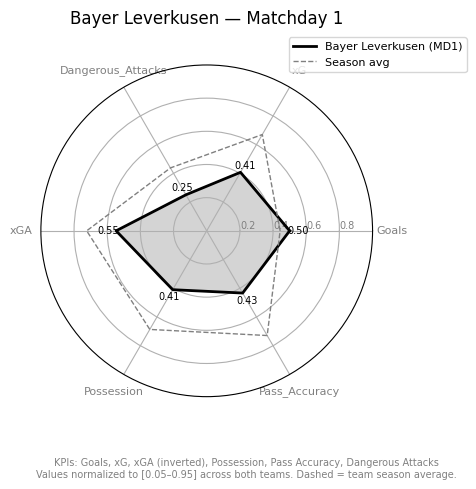

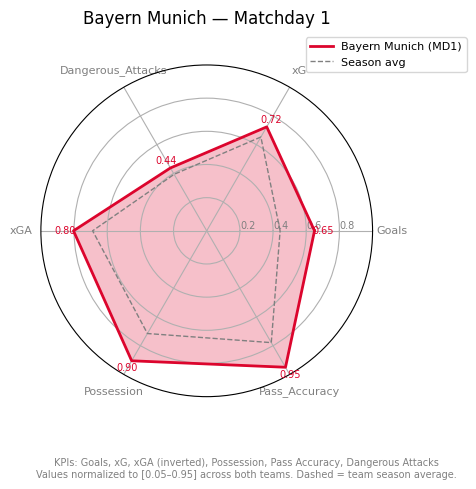


===== Matchday 2 =====


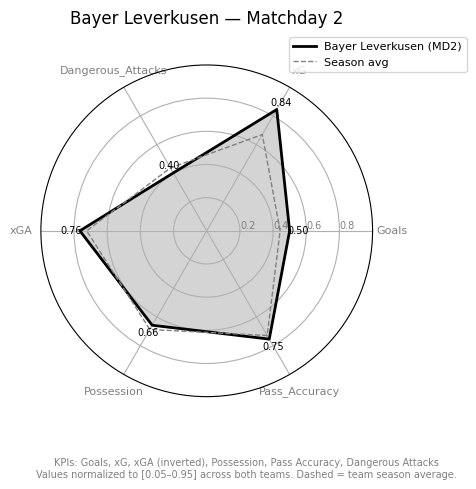

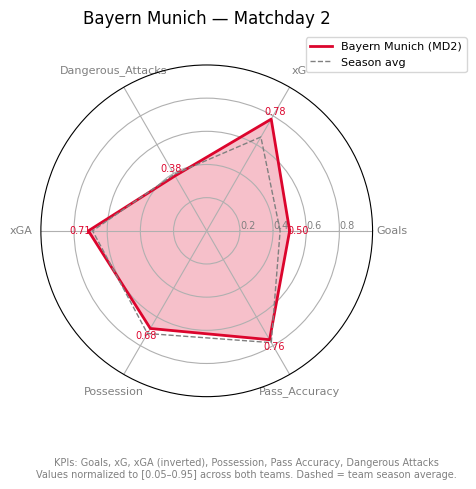


===== Matchday 3 =====


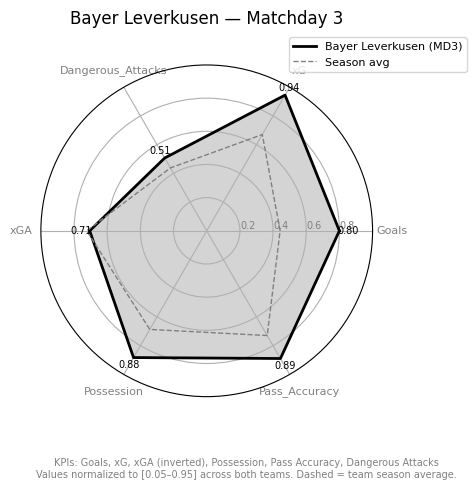

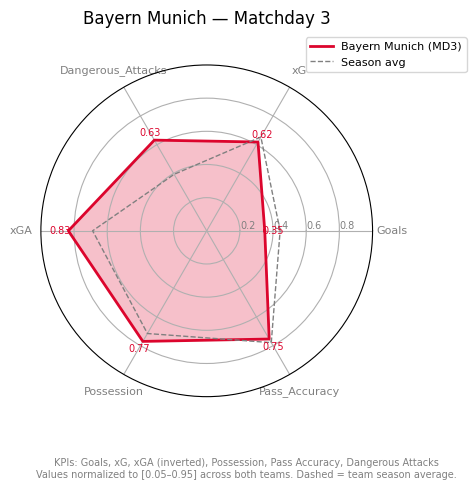


===== Matchday 4 =====


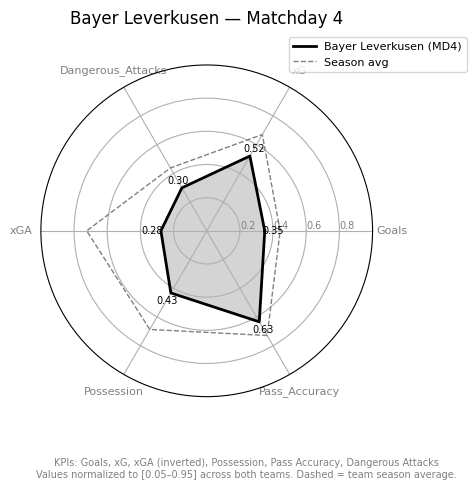

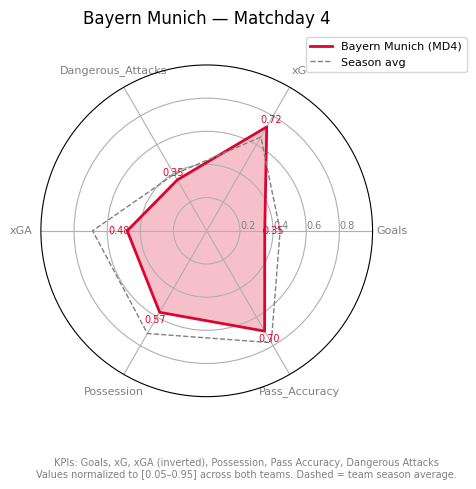


===== Matchday 5 =====


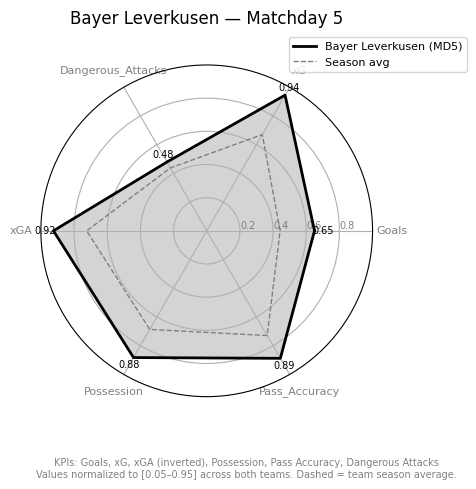

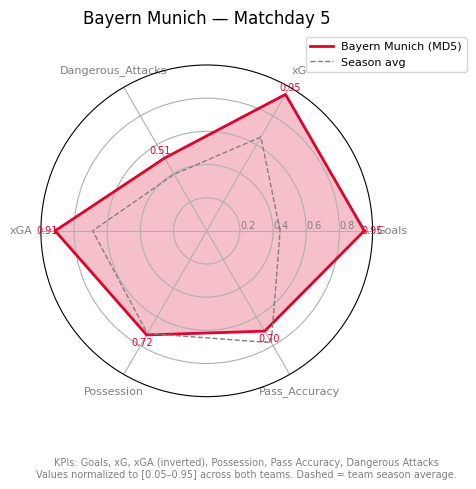


===== Matchday 6 =====


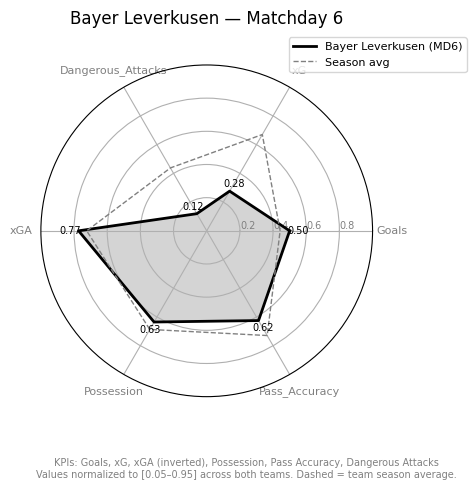

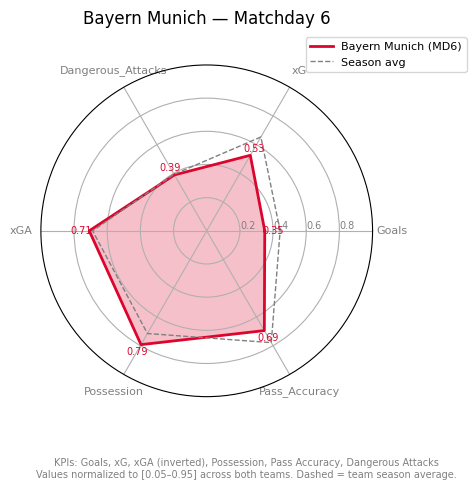


===== Matchday 7 =====


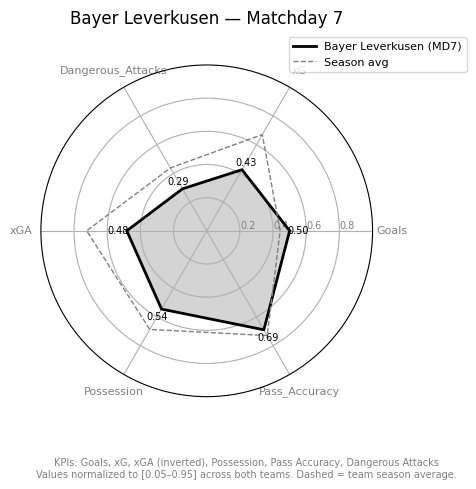

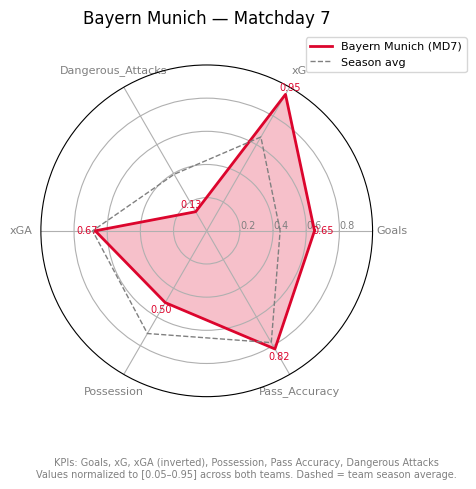


===== Matchday 8 =====


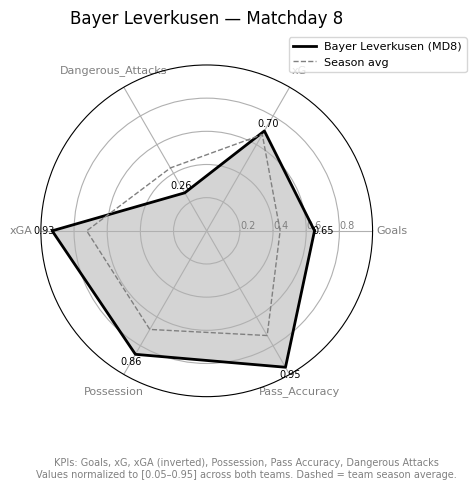

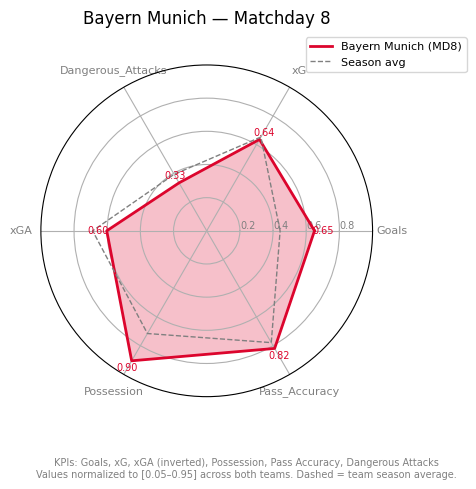


===== Matchday 9 =====


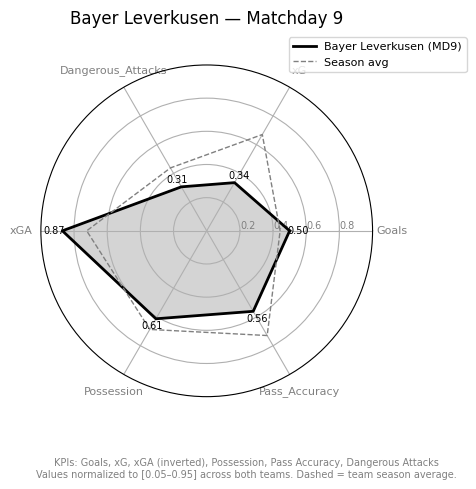

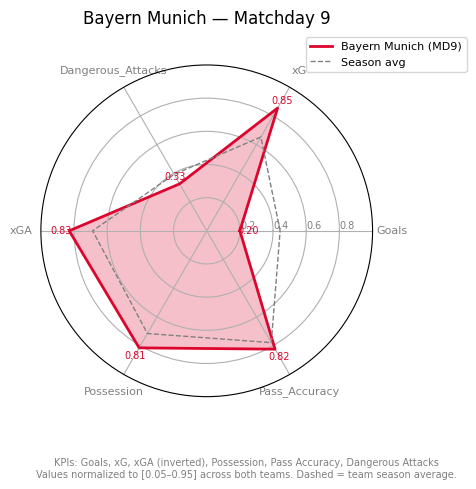


===== Matchday 10 =====


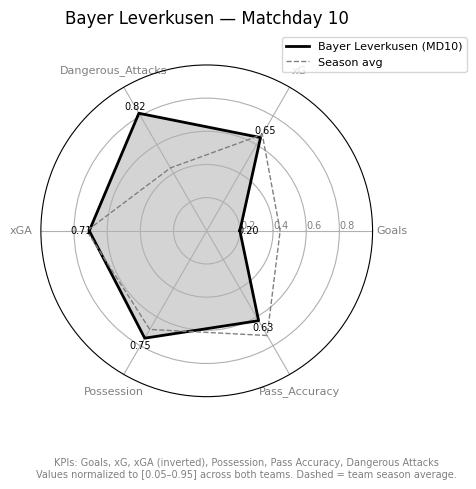

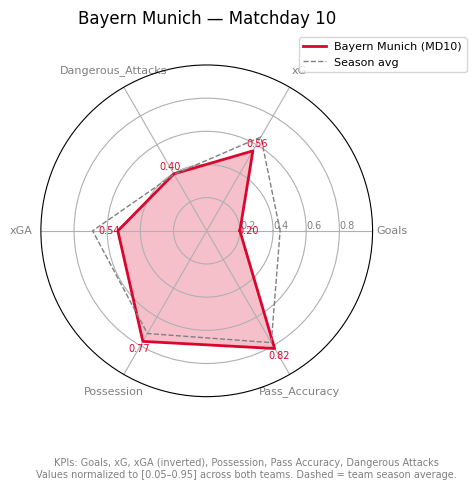


===== Matchday 11 =====


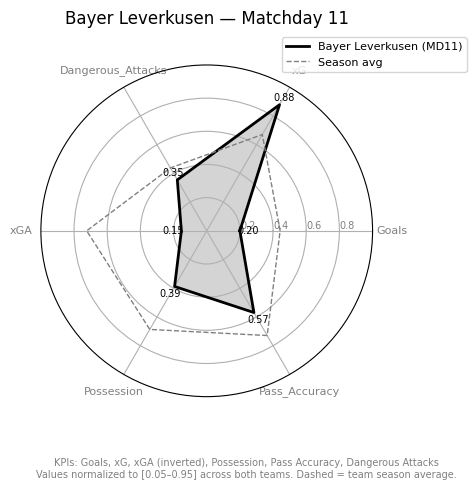

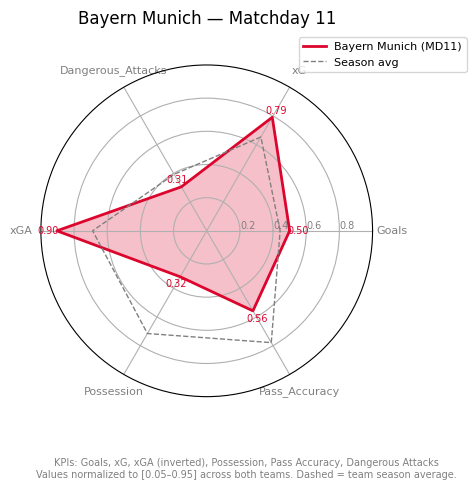


===== Matchday 12 =====


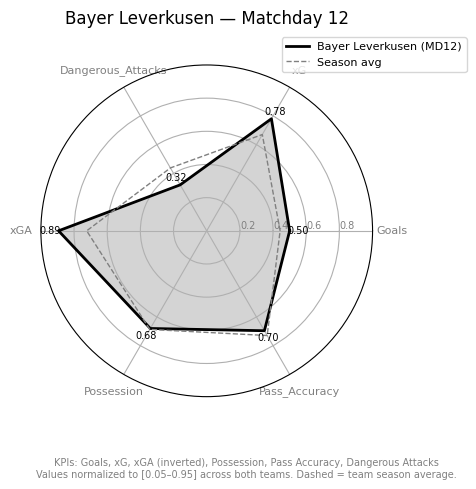

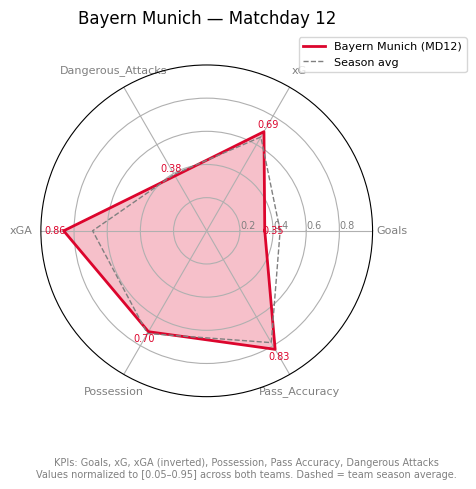


===== Matchday 13 =====


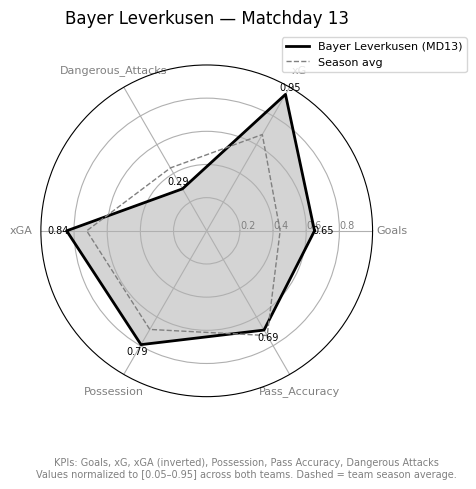

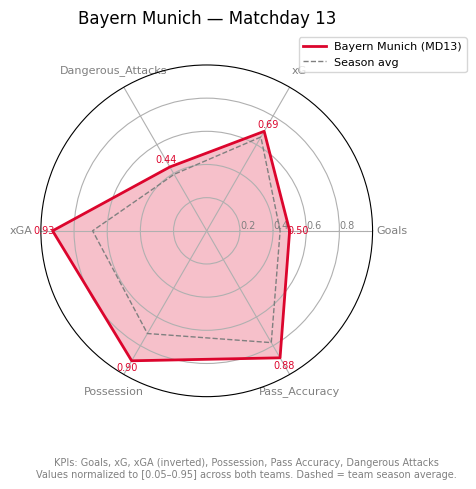


===== Matchday 14 =====


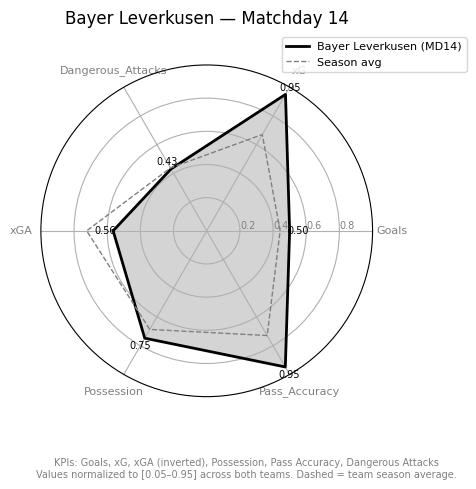

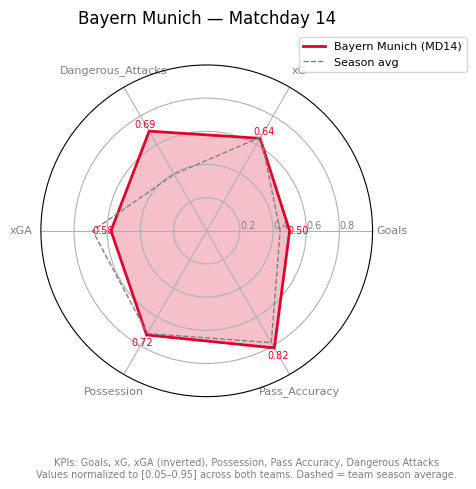


===== Matchday 15 =====


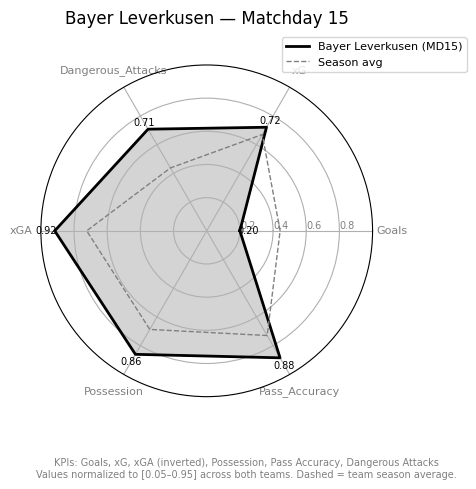

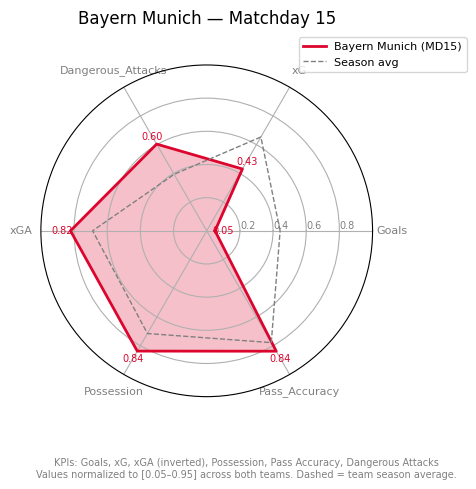


===== Matchday 16 =====


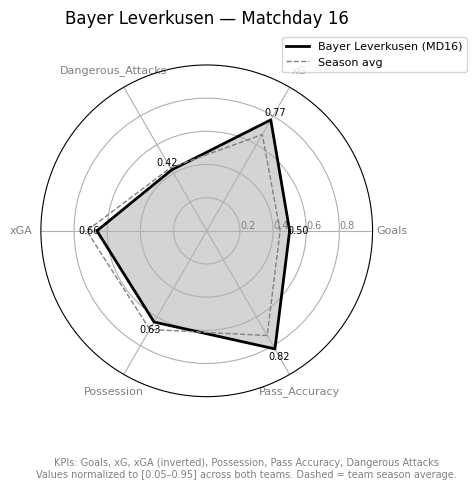

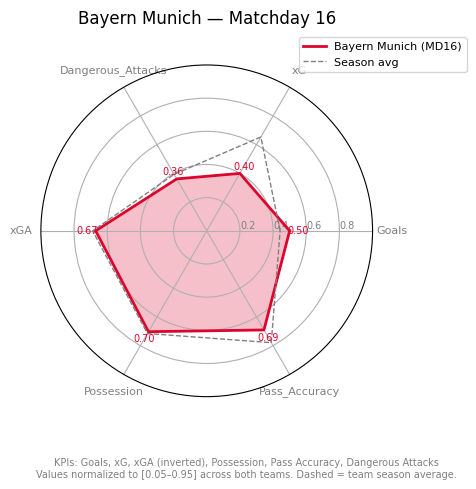


===== Matchday 17 =====


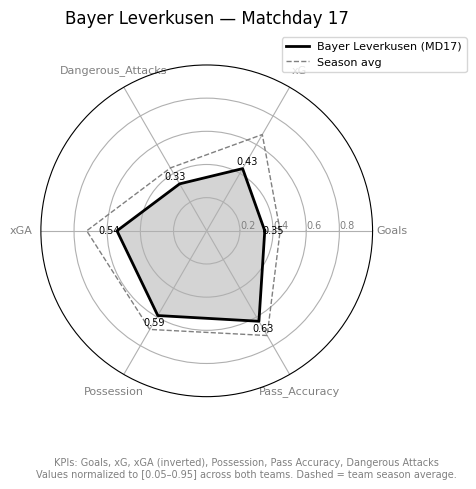

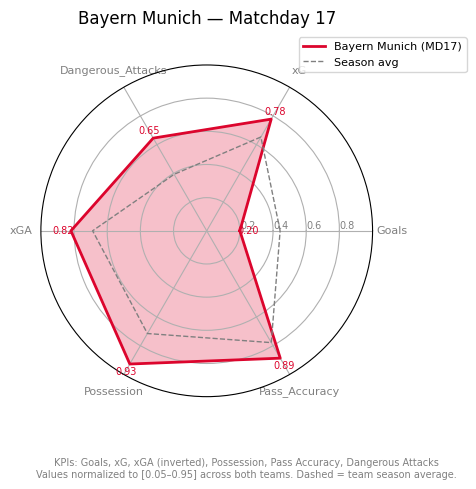


===== Matchday 18 =====


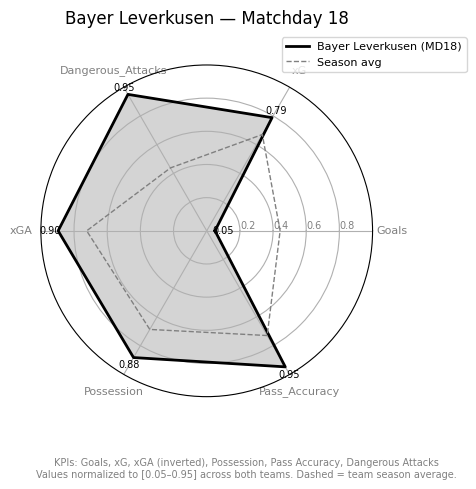

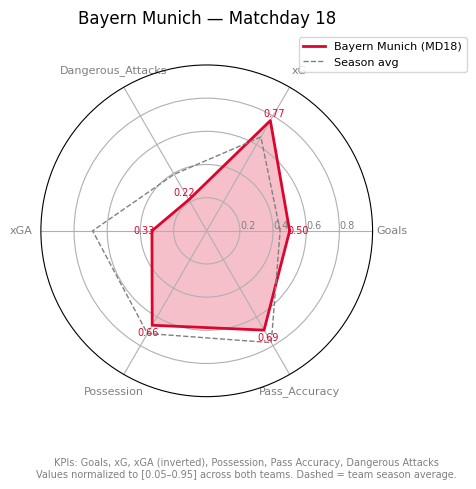


===== Matchday 19 =====


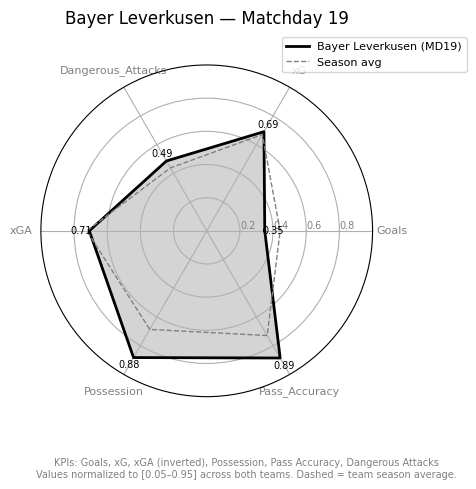

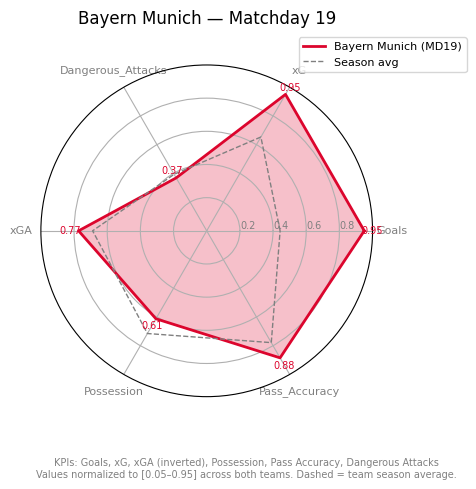


===== Matchday 20 =====


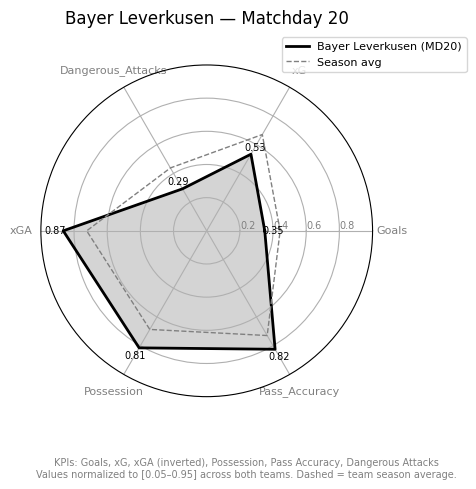

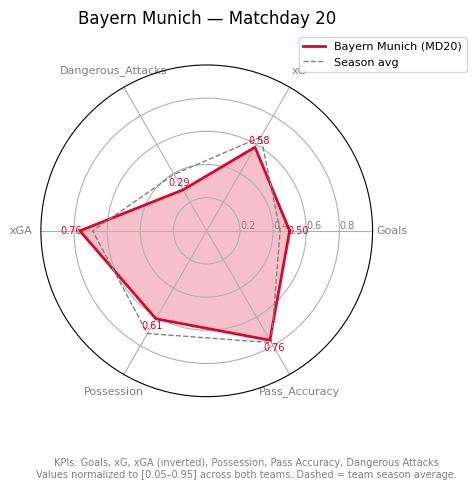


===== Matchday 21 =====


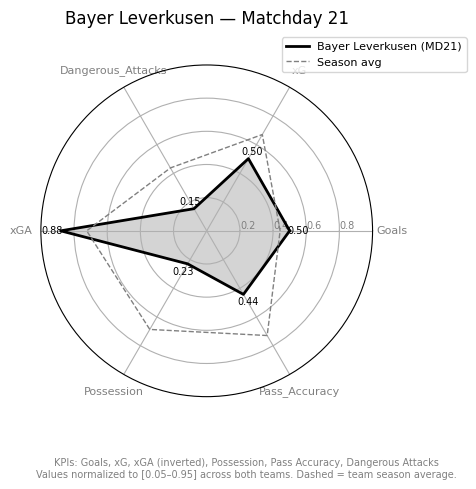

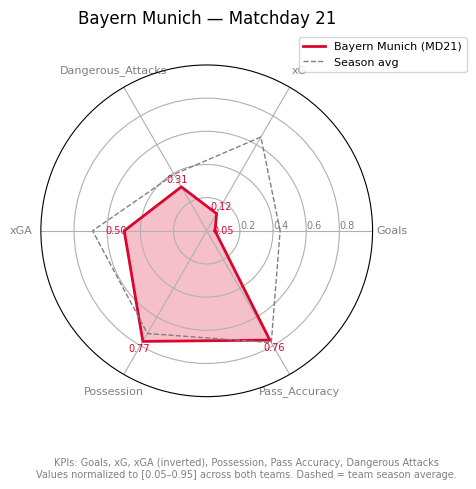


===== Matchday 22 =====


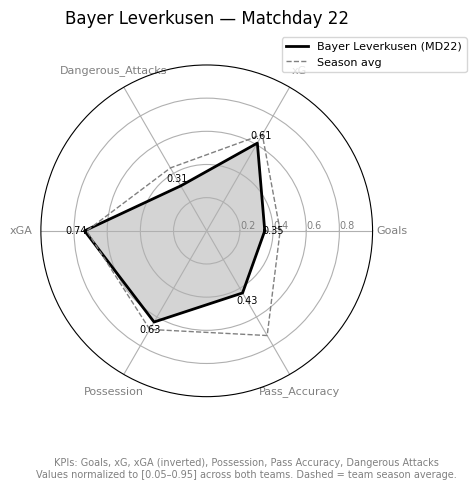

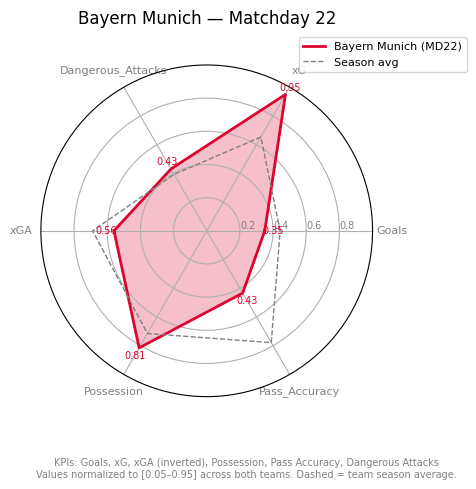


===== Matchday 23 =====


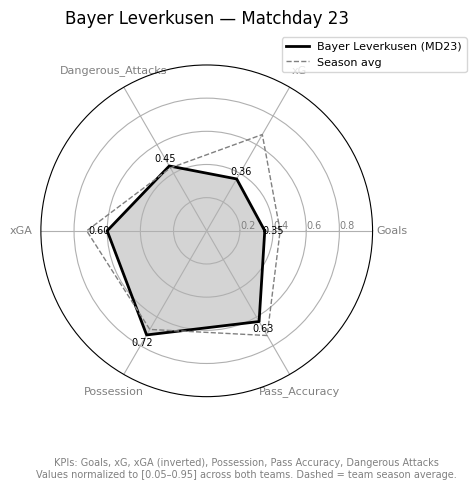

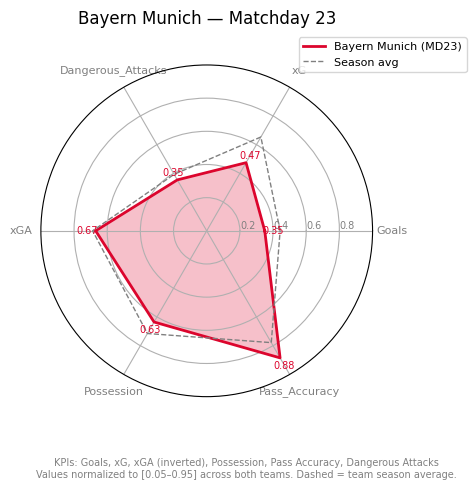


===== Matchday 24 =====


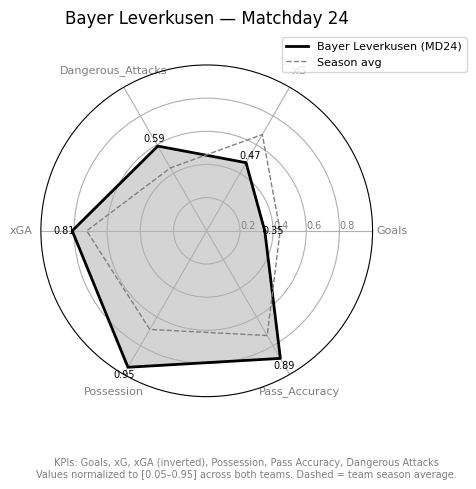

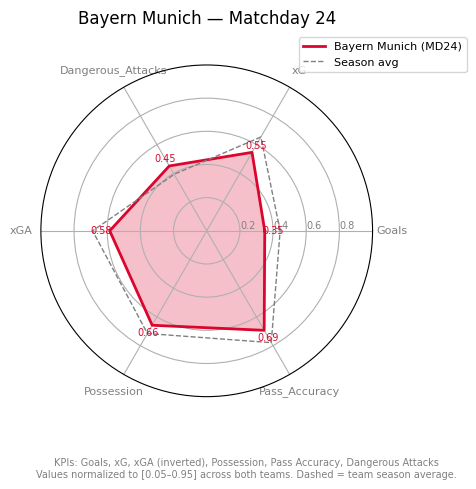


===== Matchday 25 =====


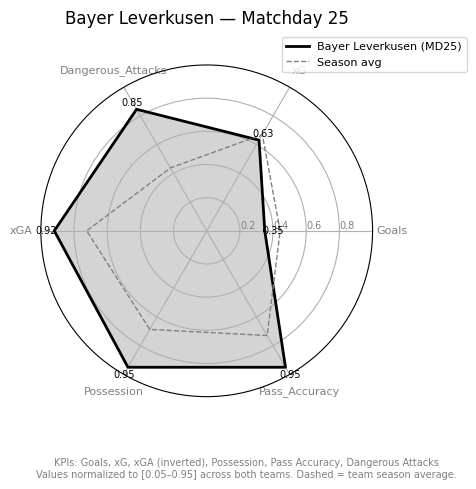

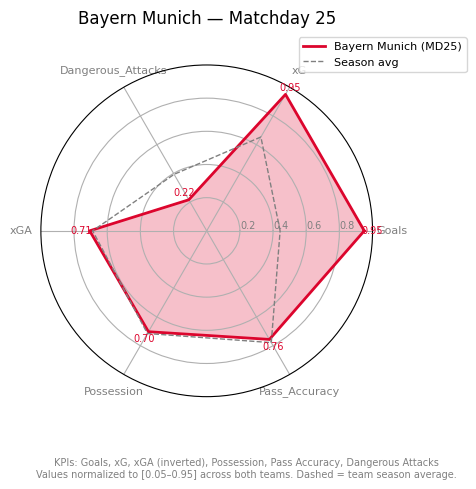


===== Matchday 26 =====


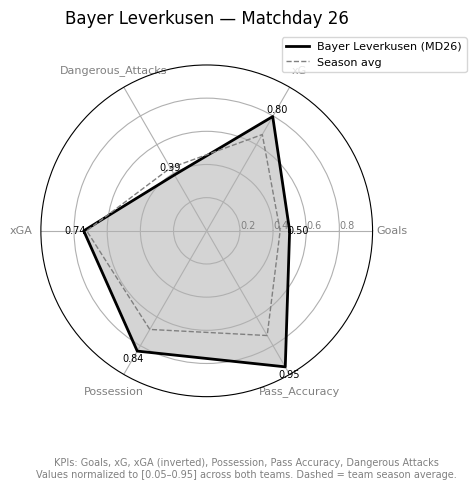

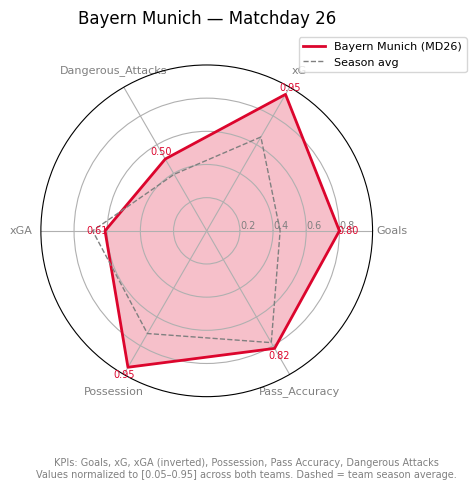


===== Matchday 27 =====


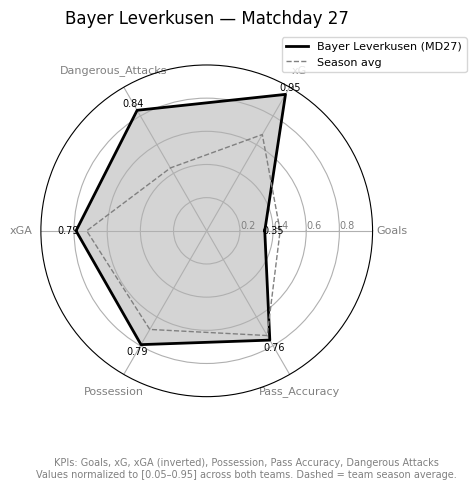

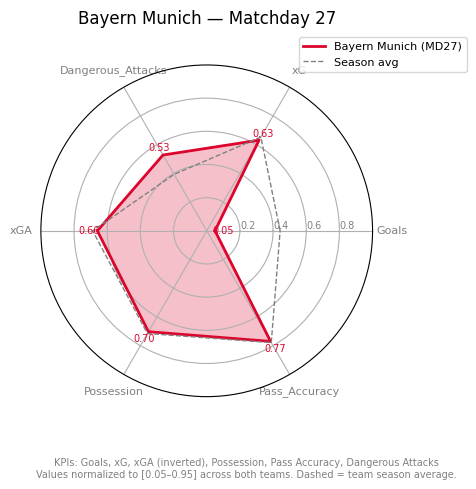


===== Matchday 28 =====


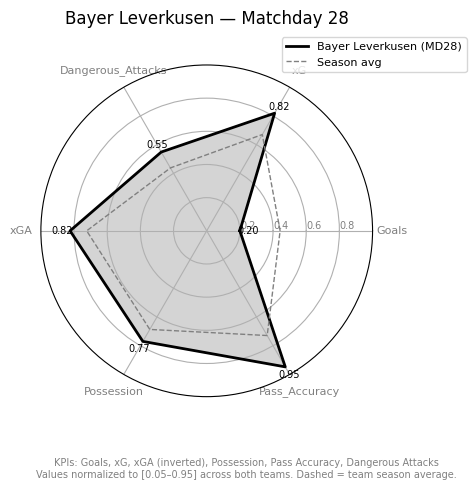

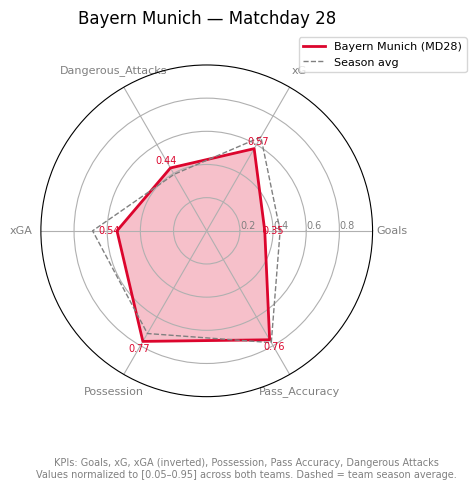


===== Matchday 29 =====


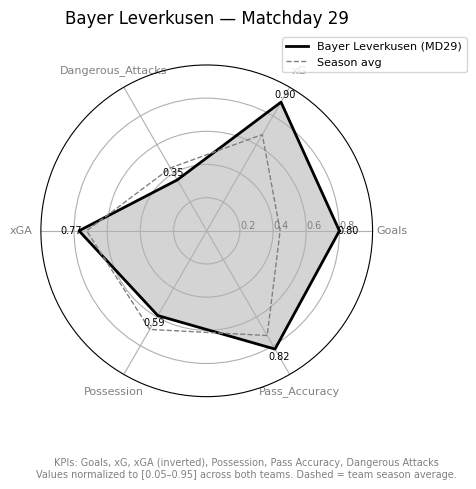

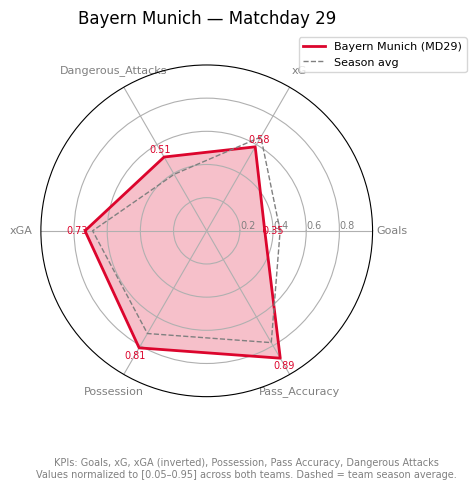


===== Matchday 30 =====


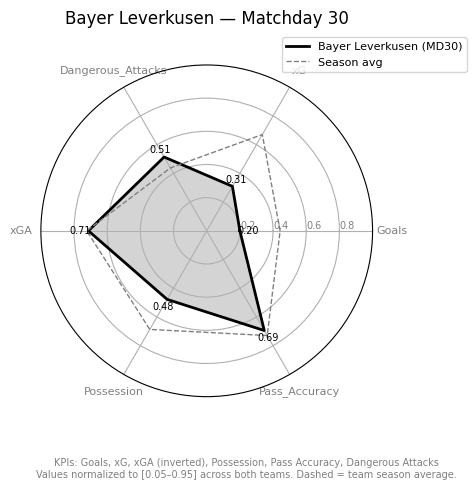

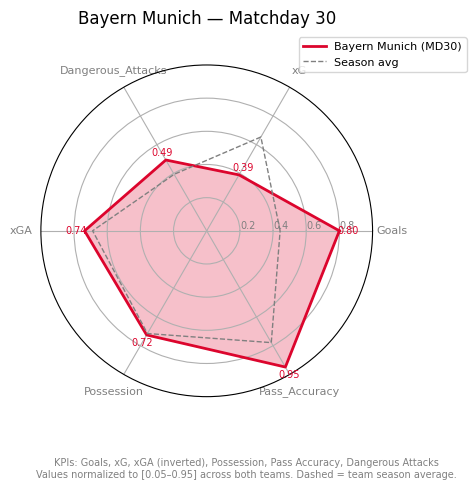


===== Matchday 31 =====


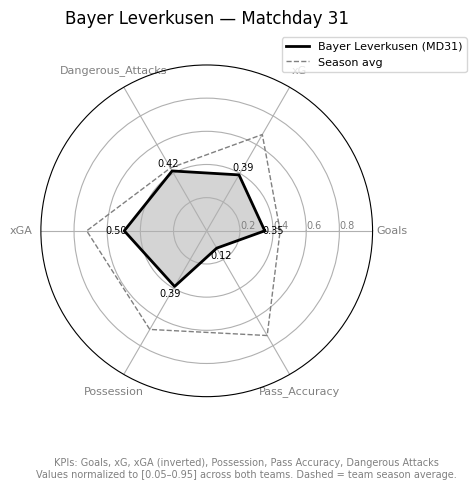

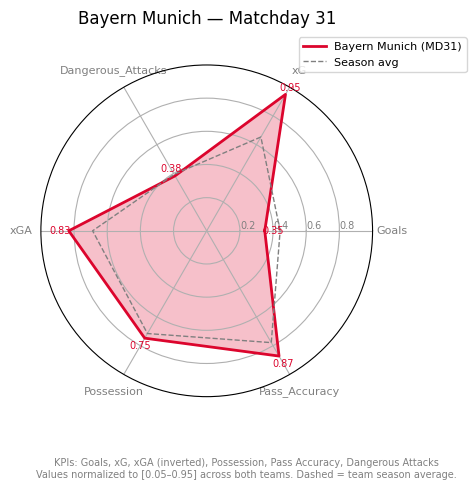


===== Matchday 32 =====


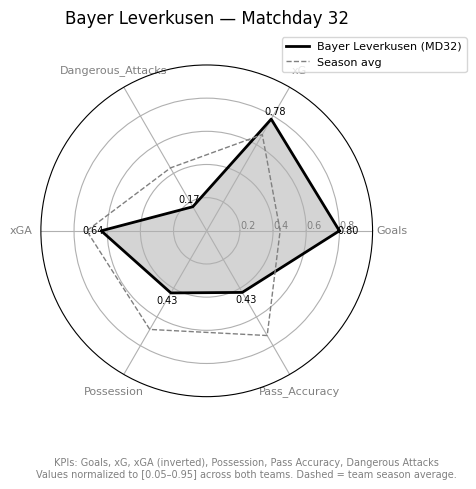

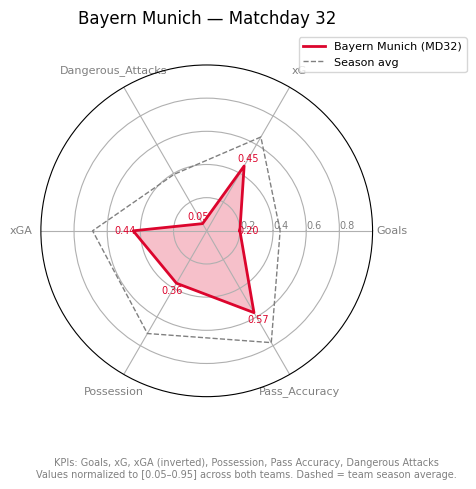


===== Matchday 33 =====


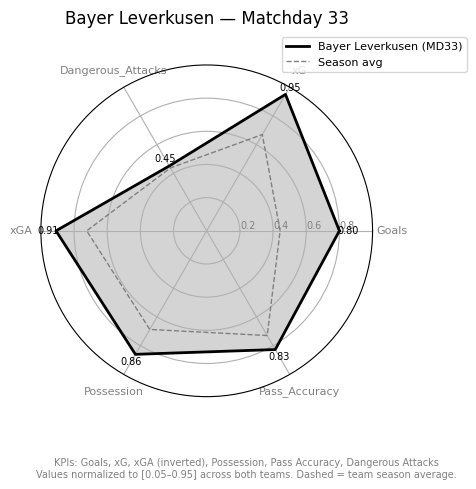

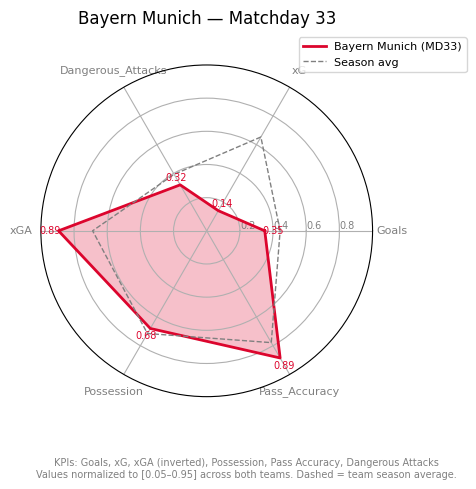


===== Matchday 34 =====


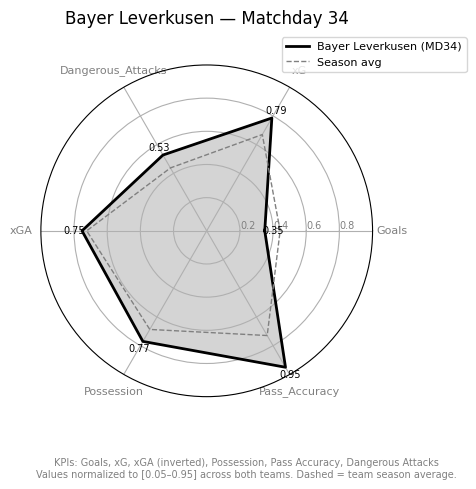

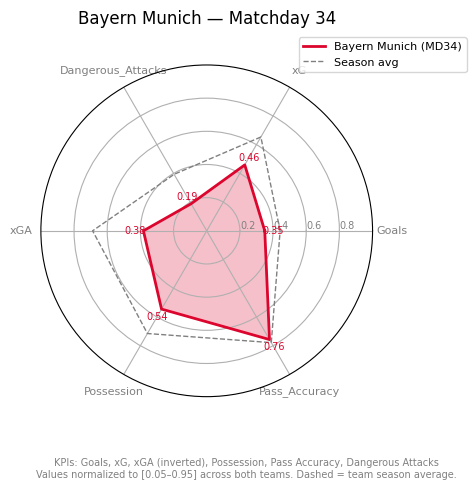

In [4]:
# ===========================================================
# CELL 4 — Generate radars per matchday for both teams
#          (Leverkusen black/gray, Bayern red)
# ===========================================================

# Use only matchdays present for BOTH teams to compare apples-to-apples
unique_mds = sorted(set(teamA_df["matchday"]).intersection(teamB_df["matchday"]))

for md in unique_mds:
    print(f"\n===== Matchday {md} =====")
    plot_radar(teamA_df, TEAM_A, md, color="#000000", fill_color="#555555")  # Leverkusen
    plot_radar(teamB_df, TEAM_B, md, color="#dc052d", fill_color="#dc052d")  # Bayern


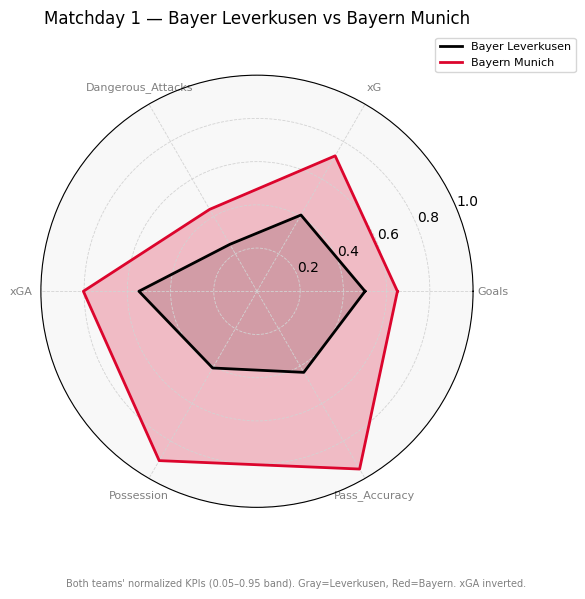

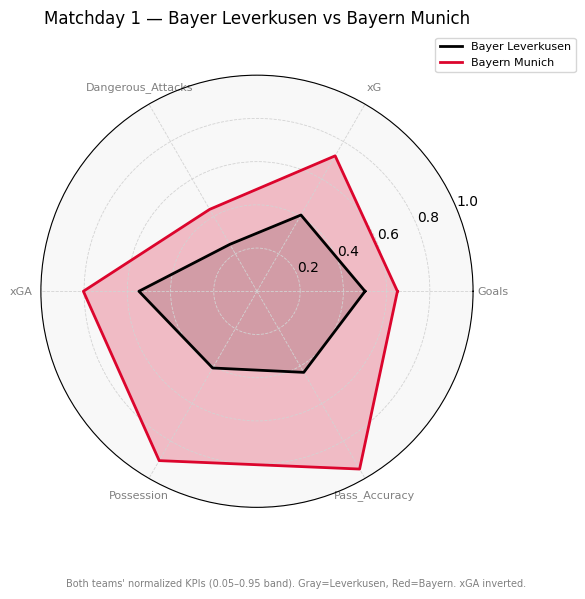

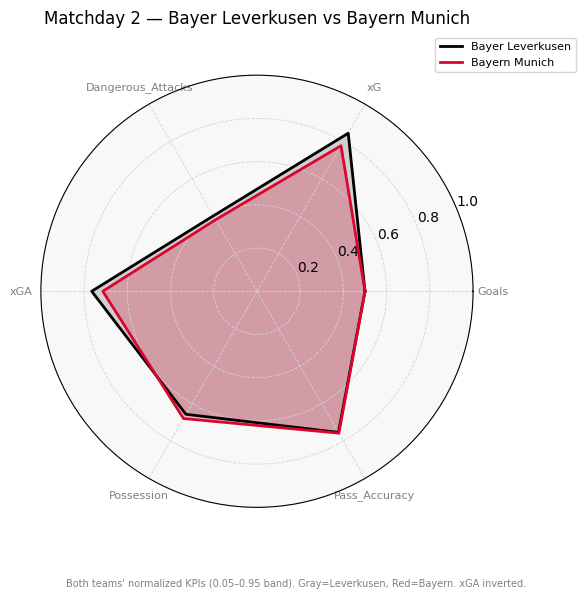

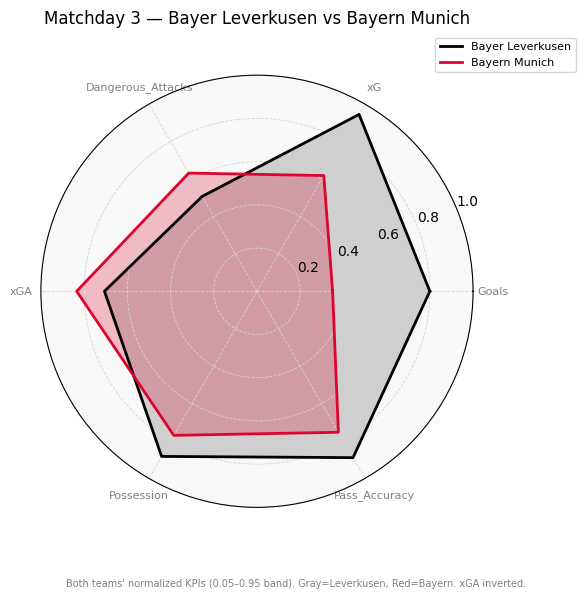

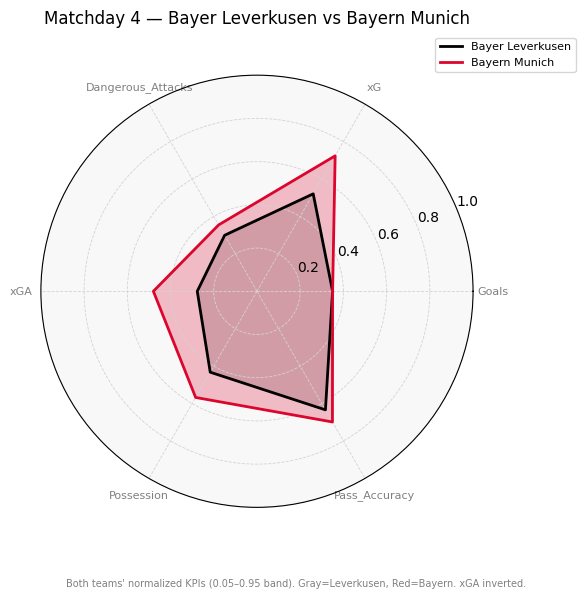

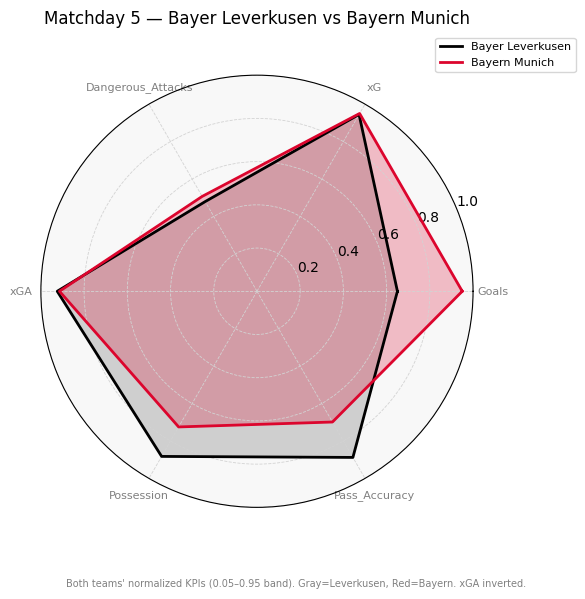

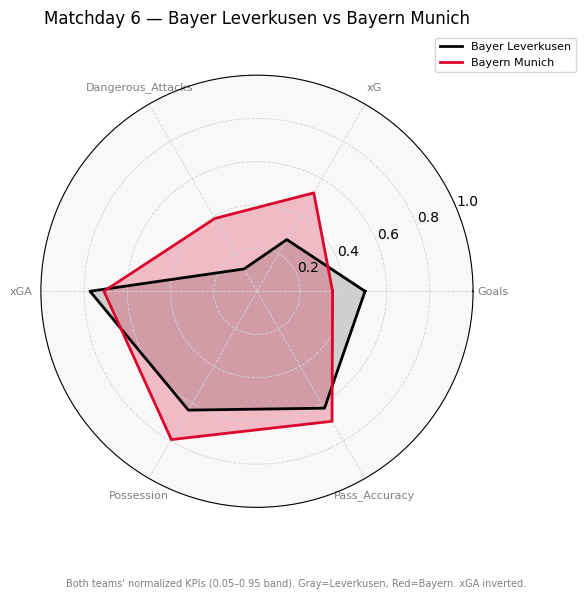

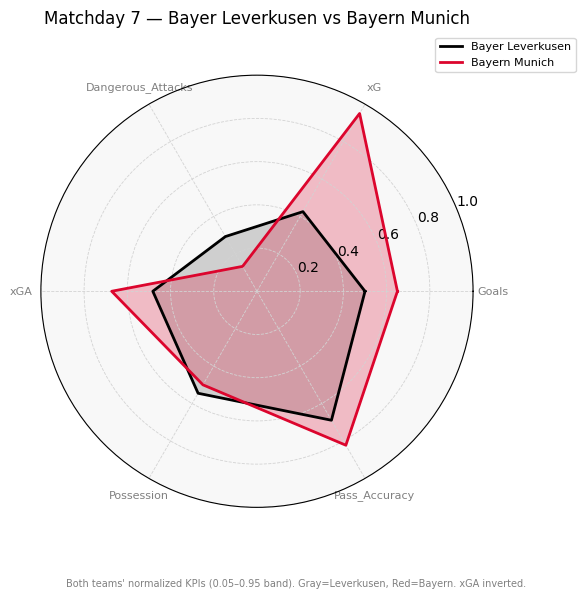

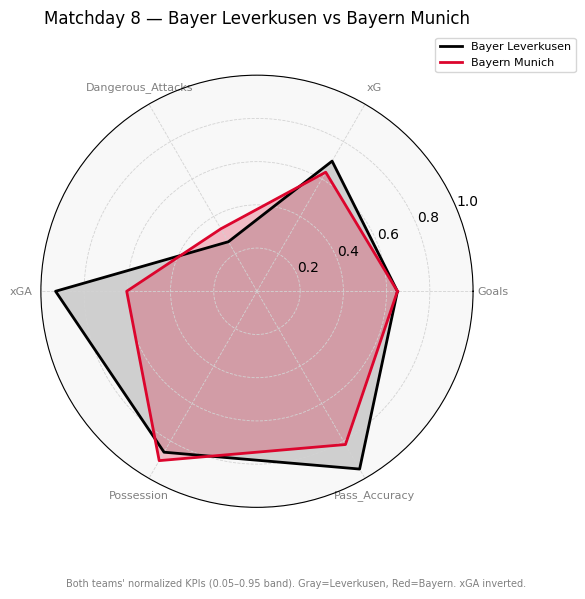

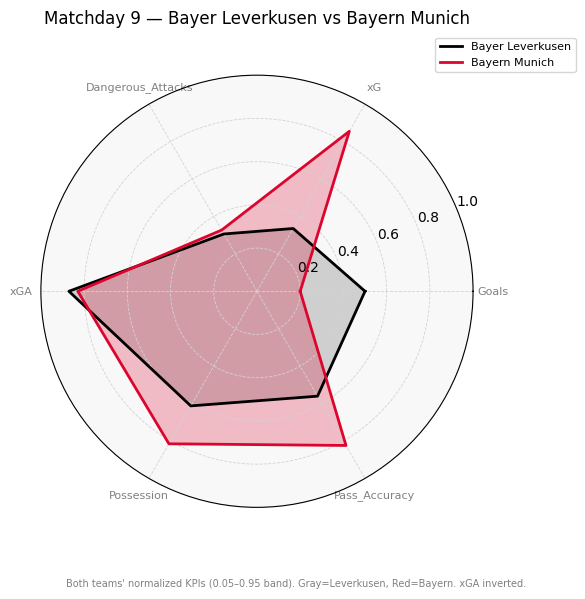

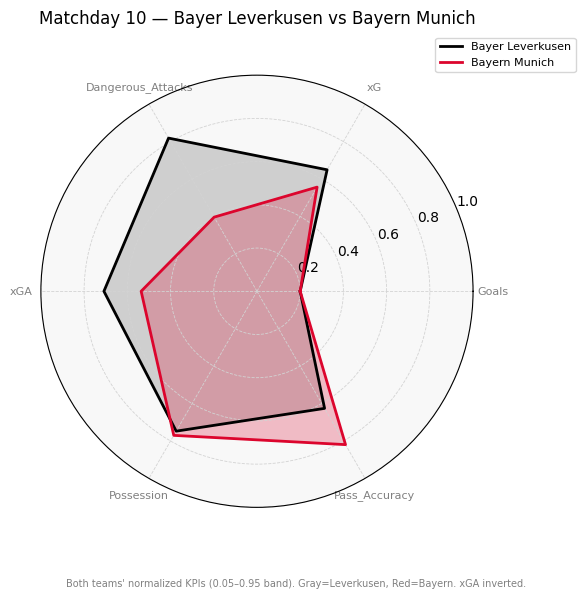

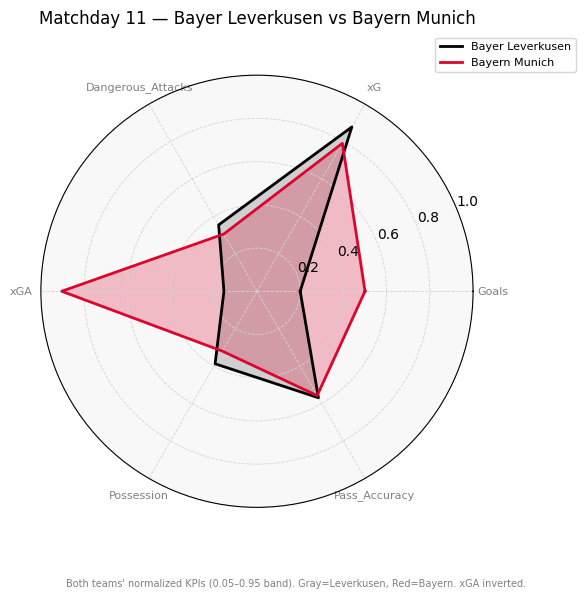

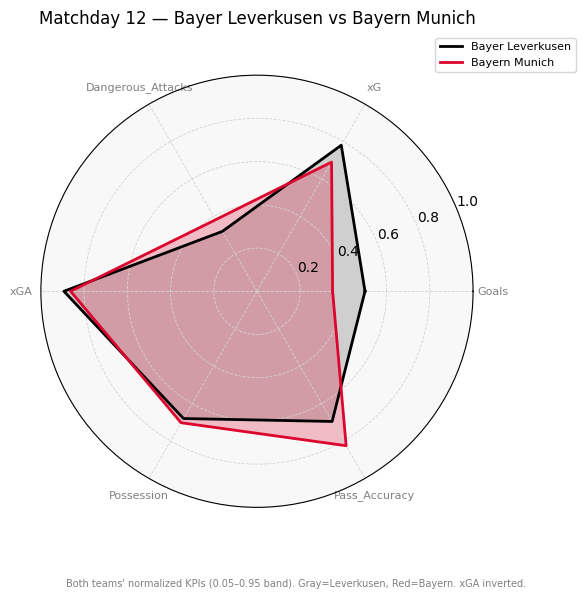

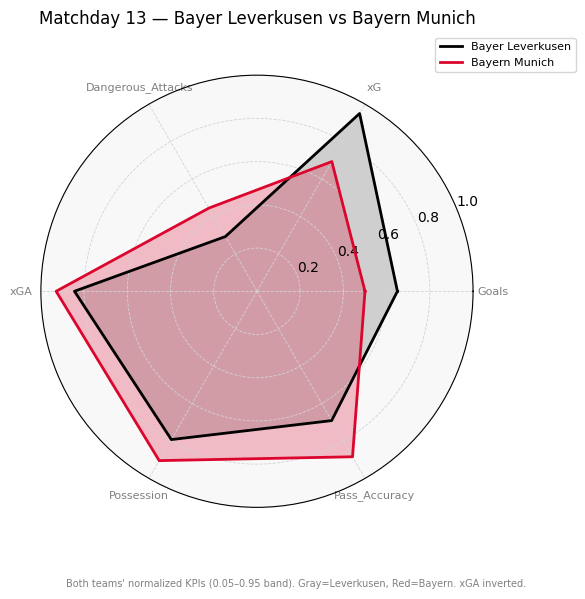

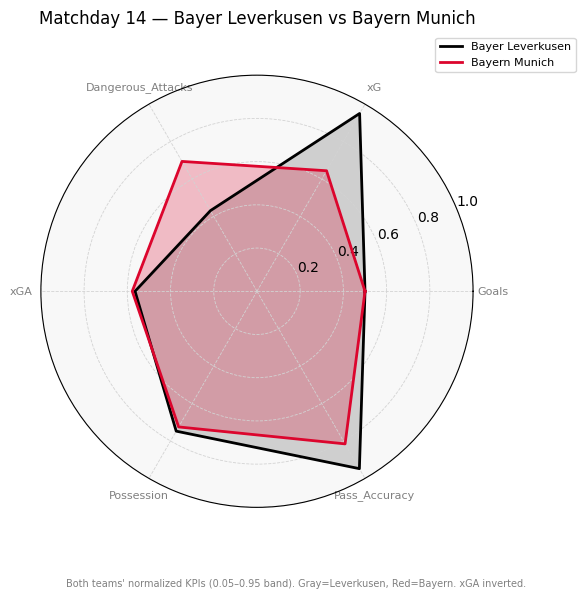

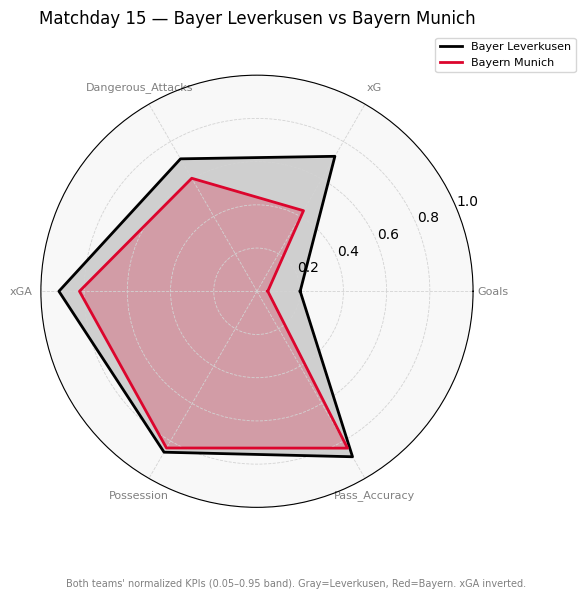

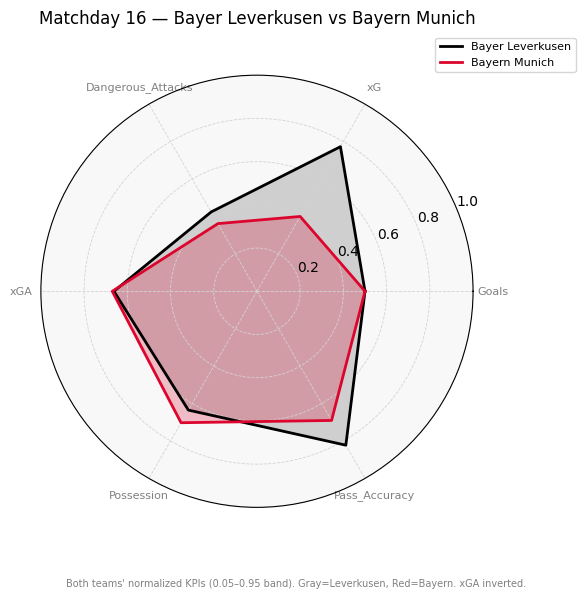

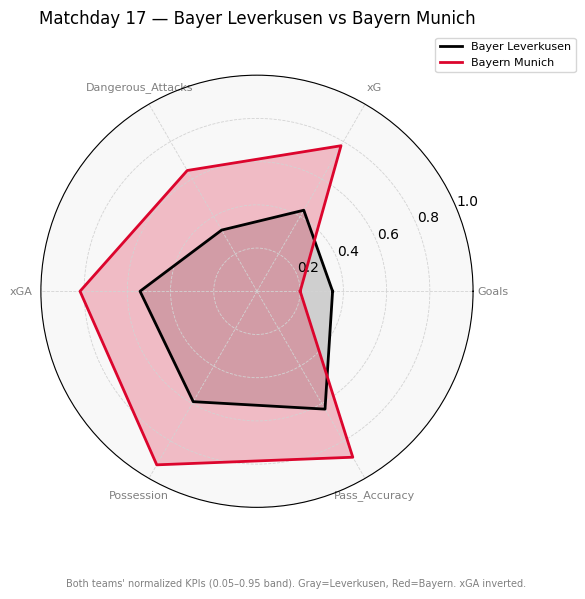

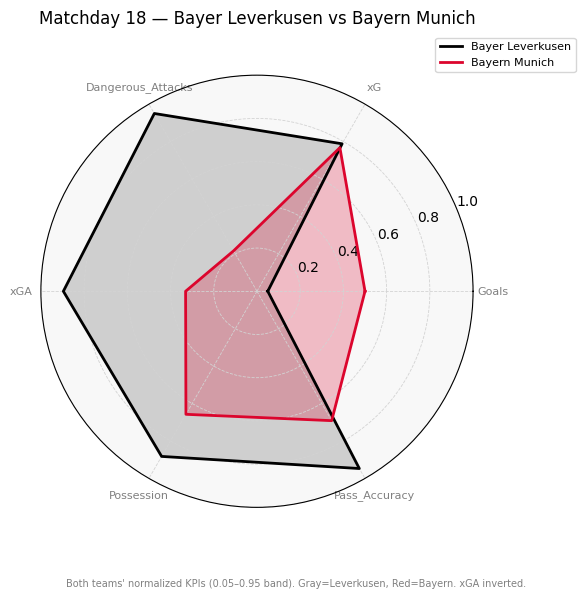

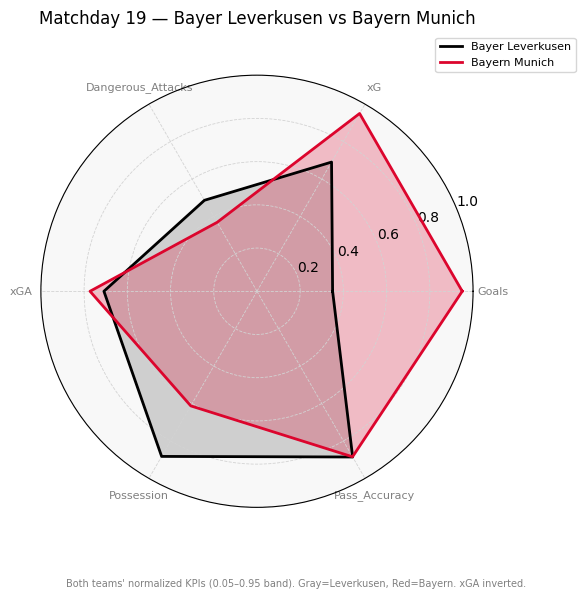

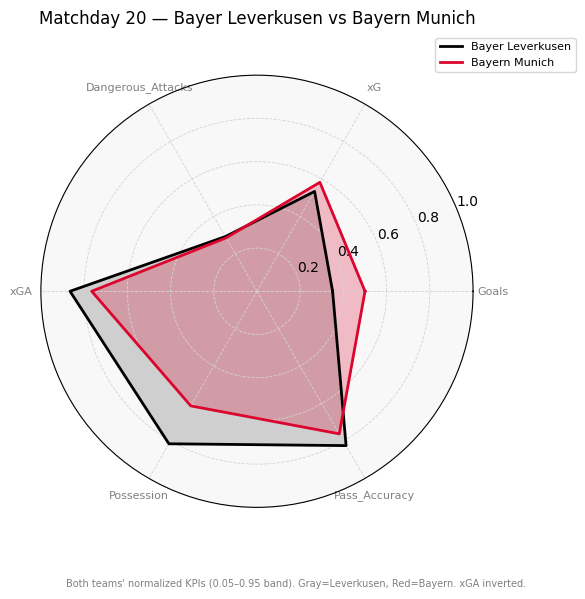

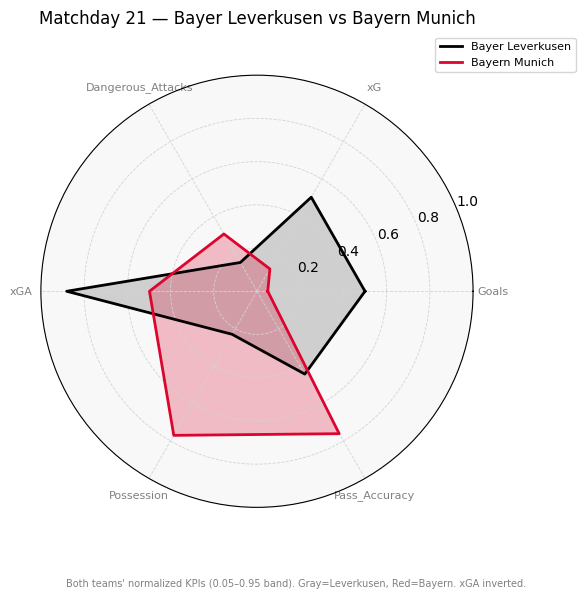

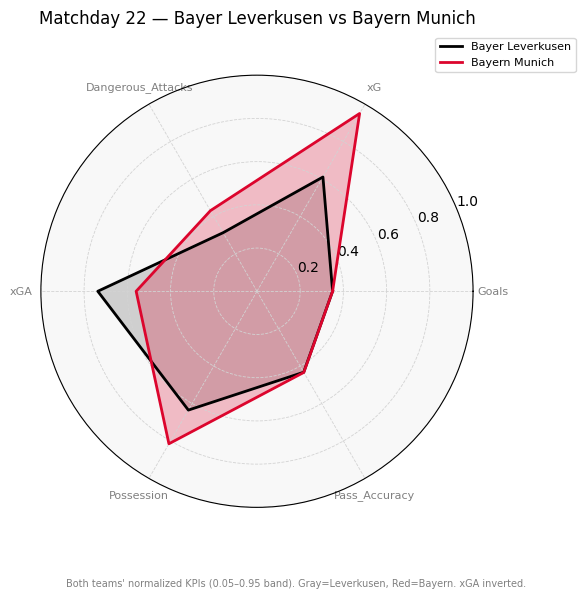

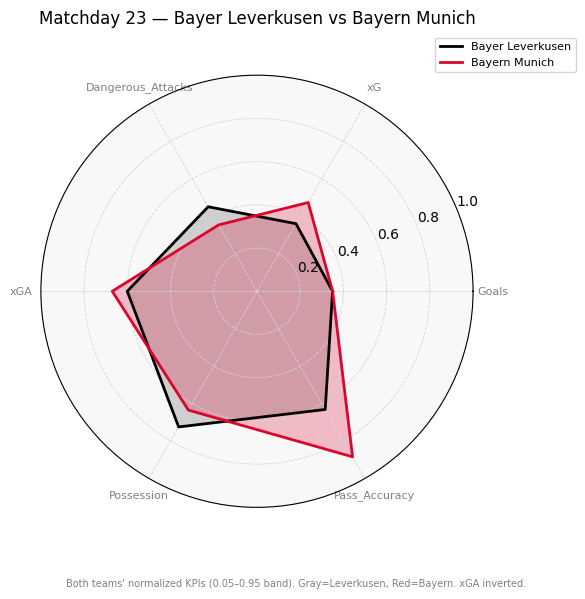

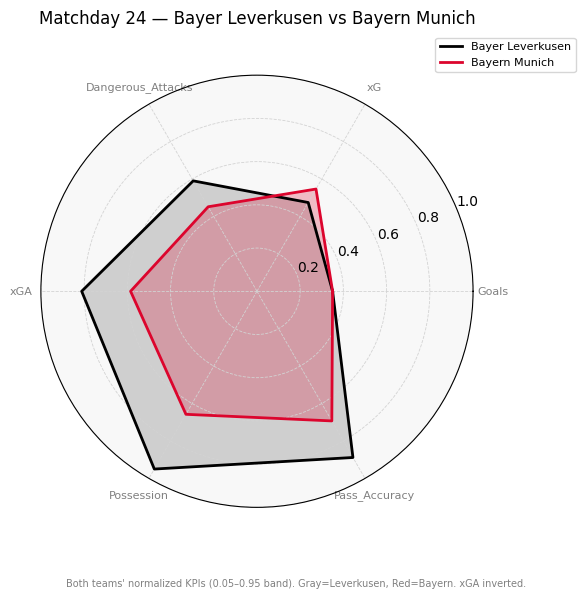

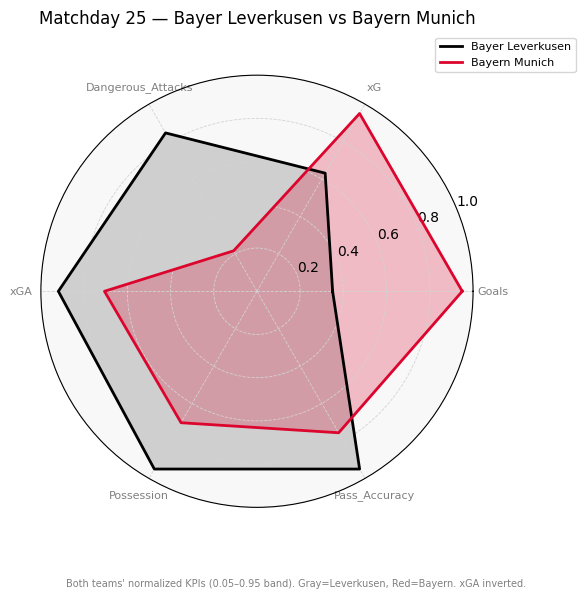

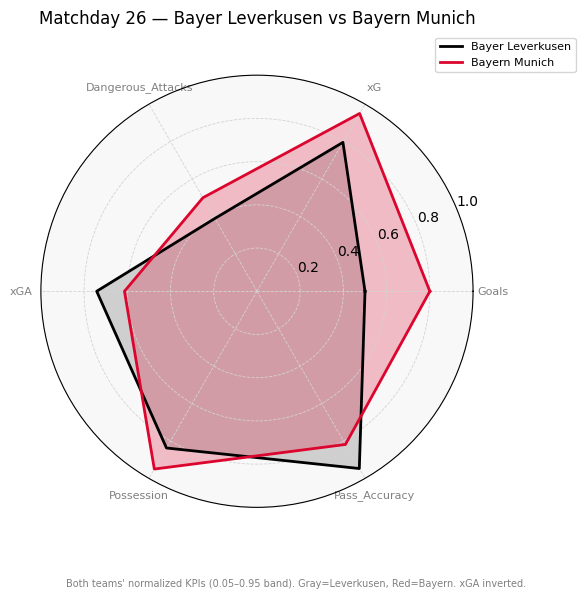

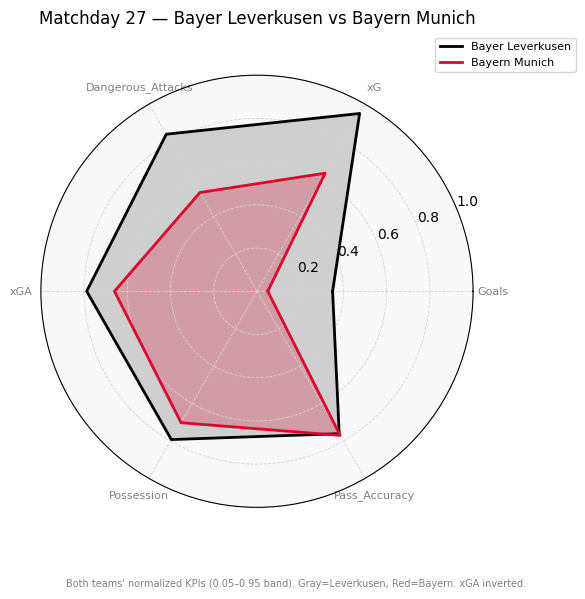

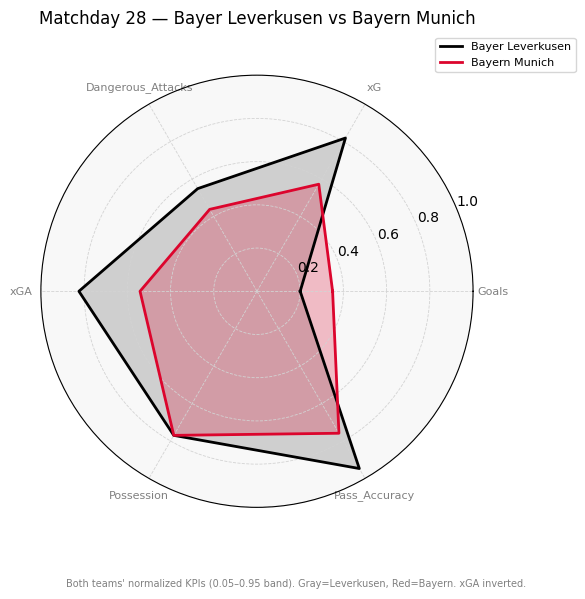

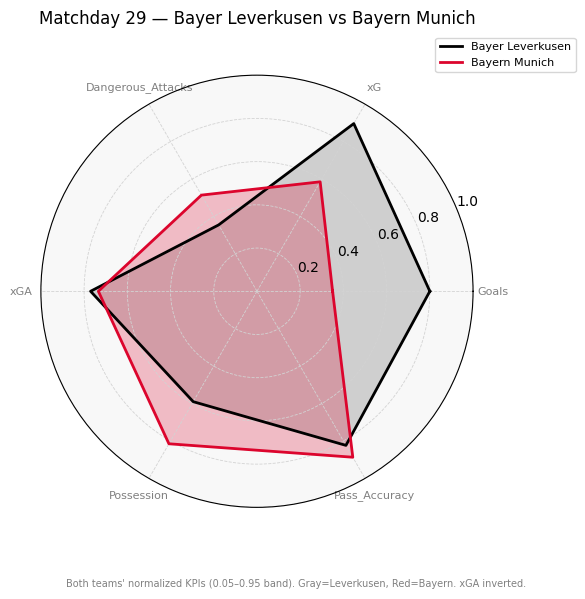

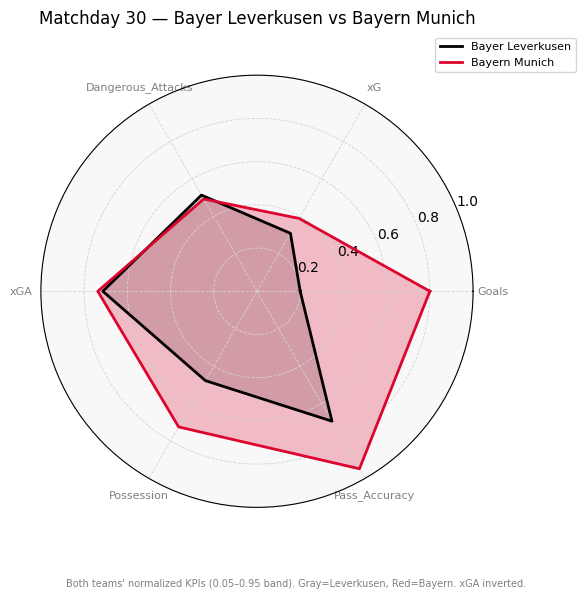

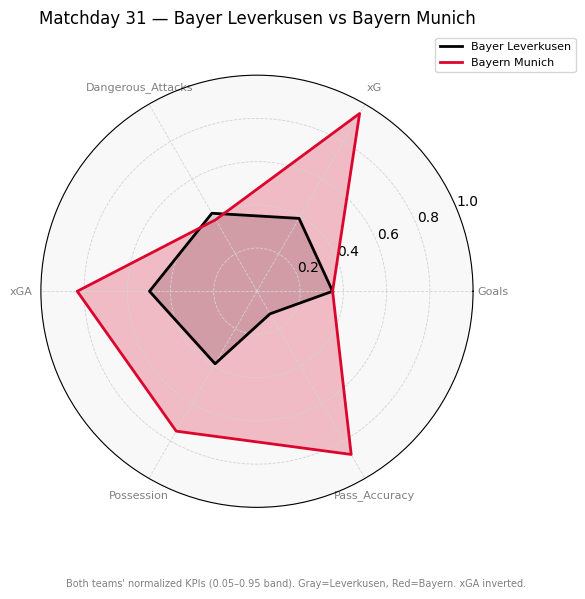

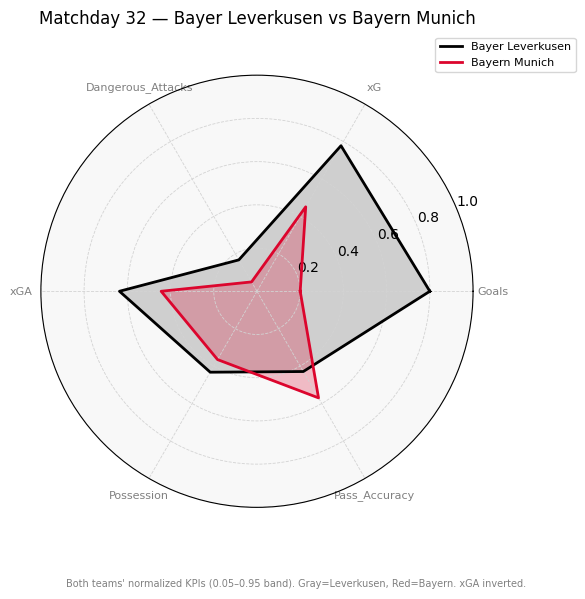

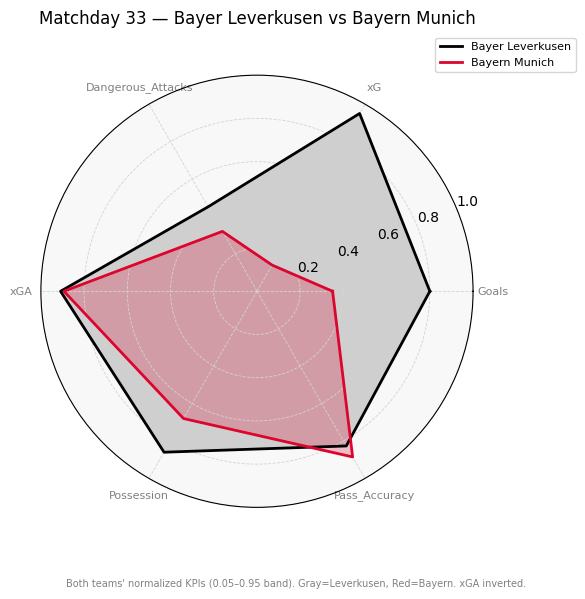

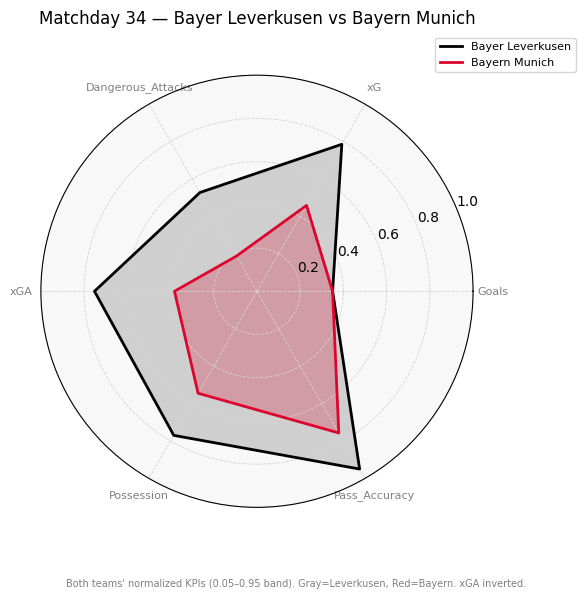

In [5]:
# ===========================================================
# CELL 5 — Combined radar comparison (A vs B on the same chart)
# ===========================================================

def plot_radar_combined(teamA_df, teamB_df, teamA_name, teamB_name, matchday):
    """
    Draw a radar with both teams overlaid for one matchday.
    Uses the same normalized KPIs and inverts xGA.
    """
    categories = ["Goals", "xG", "Dangerous_Attacks", "xGA", "Possession", "Pass_Accuracy"]
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)] + [0]

    def get_values(team_df):
        row = team_df[team_df["matchday"] == matchday].iloc[0]
        vals = [
            row["Goals_norm"],
            row["xG_norm"],
            row["Dangerous_Attacks_norm"],
            1 - row["xGA_norm"],  # invert xGA for comparability
            row["Possession_norm"],
            row["Pass_Accuracy_norm"]
        ]
        return vals + vals[:1]

    valsA = get_values(teamA_df)
    valsB = get_values(teamB_df)

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.set_ylim(0, 1)
    ax.grid(color='lightgray', linestyle='--', linewidth=0.6)
    ax.set_facecolor('#f8f8f8')

    # Team A polygon (Leverkusen)
    ax.plot(angles, valsA, color="#000000", linewidth=2, label=teamA_name)
    ax.fill(angles, valsA, color="#555555", alpha=0.25)

    # Team B polygon (Bayern)
    ax.plot(angles, valsB, color="#dc052d", linewidth=2, label=teamB_name)
    ax.fill(angles, valsB, color="#dc052d", alpha=0.25)

    plt.title(f"Matchday {matchday} — {teamA_name} vs {teamB_name}", y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1), fontsize=8)
    plt.figtext(
        0.5, -0.05,
        "Both teams' normalized KPIs (0.05–0.95 band). Gray=Leverkusen, Red=Bayern. xGA inverted.",
        ha='center', fontsize=7, color='gray'
    )
    plt.tight_layout()
    plt.show()

# Example preview for one matchday
plot_radar_combined(teamA_df, teamB_df, TEAM_A, TEAM_B, matchday=1)

# Optional: loop all shared matchdays
for md in unique_mds:
    plot_radar_combined(teamA_df, teamB_df, TEAM_A, TEAM_B, matchday=md)


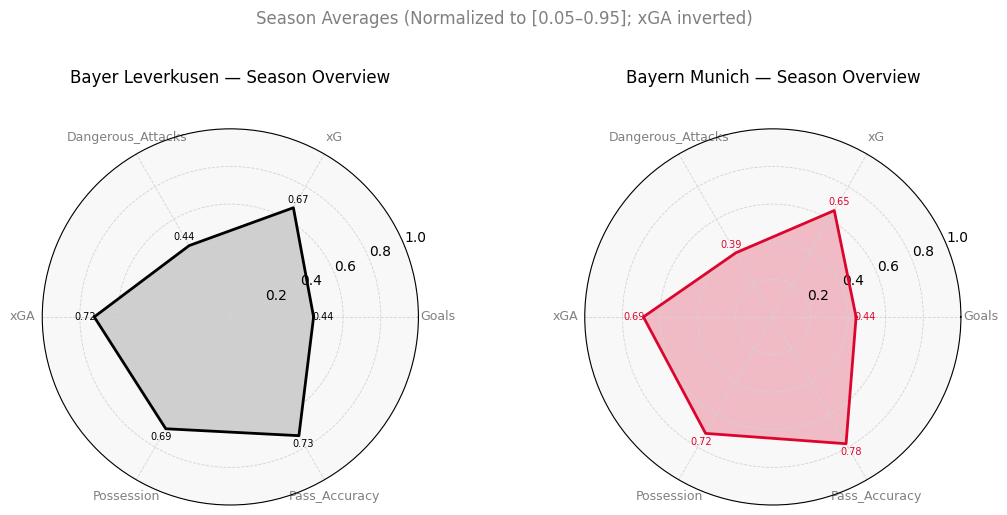

In [6]:
# ===========================================================
# CELL — Season overview radars (season averages) for both teams
#          - Computes season-average KPIs (normalized)
#          - Plots two separate radars side-by-side (one per team)
# ===========================================================

def plot_season_overview_radars(teamA_df, teamB_df, teamA_name, teamB_name):
    categories = ["Goals", "xG", "Dangerous_Attacks", "xGA", "Possession", "Pass_Accuracy"]
    cat_norm = [f"{c}_norm" for c in categories]
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)] + [0]

    def avg_vals(team_df):
        vals = team_df[cat_norm].mean().tolist()
        # invert xGA for display (lower xGA -> higher score)
        vals = [vals[i] if c != "xGA" else 1 - vals[i] for i, c in enumerate(categories)]
        return vals + vals[:1]

    A = avg_vals(teamA_df)
    B = avg_vals(teamB_df)

    fig = plt.figure(figsize=(11, 5))
    for idx, (vals, name, edge, fill) in enumerate([
        (A, teamA_name, "#000000", "#555555"),
        (B, teamB_name, "#dc052d", "#dc052d")
    ], start=1):
        ax = fig.add_subplot(1, 2, idx, polar=True)
        ax.set_ylim(0, 1)
        ax.set_facecolor('#f8f8f8')
        plt.xticks(angles[:-1], categories, color='grey', size=9)
        ax.grid(color='lightgray', linestyle='--', linewidth=0.6)
        ax.plot(angles, vals, color=edge, linewidth=2)
        ax.fill(angles, vals, color=fill, alpha=0.25)
        ax.set_title(f"{name} — Season Overview", y=1.1, fontsize=12)
        # annotate values
        for ang, v in zip(angles[:-1], vals[:-1]):
            ax.text(ang, min(v + 0.05, 1.0), f"{v:.2f}", ha='center', va='center', fontsize=7, color=edge)

    fig.suptitle("Season Averages (Normalized to [0.05–0.95]; xGA inverted)", y=1.02, fontsize=12, color='gray')
    plt.tight_layout()
    plt.show()

# Run it
plot_season_overview_radars(teamA_df, teamB_df, TEAM_A, TEAM_B)
